In [1]:
import numpy, scipy
import trig
import fibonacci_sphere
import xyzfield
from matplotlib import pyplot
import matplotlib
from mpl_toolkits import basemap
%matplotlib nbagg

## funciones de base del modelo R-SCHA-2D

**tiempo**
- splines (primero normales, luego Cox-de Boor)
- regularización: d²/dt² B²

**espacio**
- funciones de Legendre de grado real (k - m par), hasta Kmax (~2)
- funciones de Mehler de grado -1/2, hasta Mmax (~1)
- regularización: B² (diagonal)

#### parámetros del modelo

In [38]:
lon_c = 20; lat_c = 45; colat_0 = 24.8; colat_0big = 50;
theta_c, phi_c, theta_0, theta_0big = numpy.deg2rad((90-lat_c, lon_c, colat_0, colat_0big))

In [4]:
m_max = 1; k_max = 2

##### funciones asociadas de Legendre

vamos a hallar el grado

In [55]:
import scha
ms = numpy.arange(0, k_max+1)
k, m, n = scha.join_roots(scha.degree(ms, theta_0big, 10))
k = numpy.array(k); m = numpy.array(m); n = numpy.array(n)
print("{0:>5} {1:>5} {2:>10}".format("k", "m", "n"))
print("-"*27)
for kk, mm, nn in zip(k, m, n):
    print("{0:>5} {1:>5} {2:10.4f}".format(kk,mm,nn))

    k     m          n
---------------------------
    0     0     0.0000
    1     0     2.2400
    1     1     1.7834
    1    -1     1.7834
    2     0     3.9207
    2     1     3.9207
    2    -1     3.9207
    2     2     3.2740
    2    -2     3.2740


condición de k - m par

In [56]:
km_even = (numpy.array(k)-numpy.abs(m)) % 2 == 0
k_even, m_even, n_even = k[km_even], m[km_even], n[km_even]
print("{0:>5} {1:>5} {2:>10}".format("k", "m", "n"))
print("-"*27)
for kk, mm, nn in zip(k_even, m_even, n_even):
    print("{0:>5} {1:>5} {2:10.4f}".format(kk,mm,nn))

    k     m          n
---------------------------
    0     0     0.0000
    1     1     1.7834
    1    -1     1.7834
    2     0     3.9207
    2     2     3.2740
    2    -2     3.2740


#### dibujemos las funciones de base

In [60]:
thetav, phiv = fibonacci_sphere.grid(n=8000)
in_cap = trig.angulardist(thetav, phiv, 0, 0) < theta_0big
thetav = thetav[in_cap]; phiv = phiv[in_cap]

##### funciones asociadas de Legendre

<IPython.core.display.Javascript object>


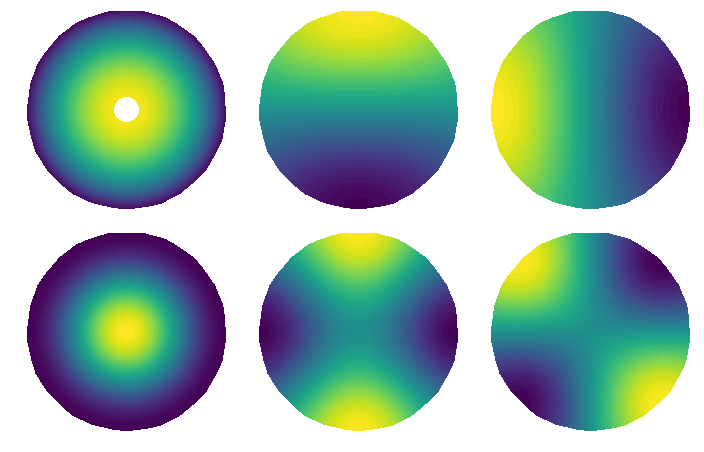

In [62]:
fig, axes = pyplot.subplots(2, len(k_even)//2, subplot_kw={'aspect':'equal'}, figsize=(4*len(k_even)//2, 8))
axes=axes.reshape(len(k_even))
fig.tight_layout()


for kk, mm, nn, ax in zip(k_even, m_even, n_even, axes):
    m_abs = numpy.abs(mm)
    z = scha.lpmv(m_abs, nn, numpy.cos(thetav))
    if mm >= 0:
        z = z * numpy.cos(m_abs*phiv)
    else:
        z = z * numpy.sin(m_abs*phiv)
    scha.polar_tricontour(z, thetav, phiv, theta_0big, ax, cmap='viridis', scale="minmax")
    ax.axis('off')

##### funciones de Mehler

In [9]:
import mehler

<IPython.core.display.Javascript object>


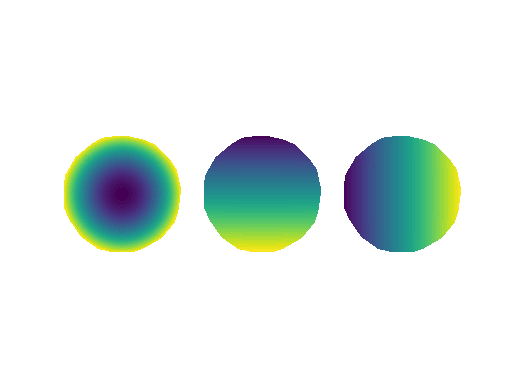

In [59]:
m_mehler = numpy.array((0, 1, -1))
fig, axes = pyplot.subplots(1, len(m_mehler), subplot_kw={'aspect':'equal'})

for mm, ax in zip(m_mehler, axes):
    m_abs = numpy.abs(mm)
    z = mehler.mehler_t(m_abs, 0, thetav, theta_0, normalized=True)
    if mm >= 0:
        z = z * numpy.cos(m_abs*phiv)
    else:
        z = z * numpy.sin(m_abs*phiv)
    scha.polar_tricontour(z, thetav, phiv, theta_0, ax, cmap='viridis', scale="minmax")
    ax.axis('off')

In [32]:
a=[]
for mmm in m_mehler:
    a.append(rscha.synth_field(((), (), ()), (mmm,), (1, 1, 1), thetav, phiv, theta_0))

In [21]:
a[0][0].shape

(368,)

<IPython.core.display.Javascript object>


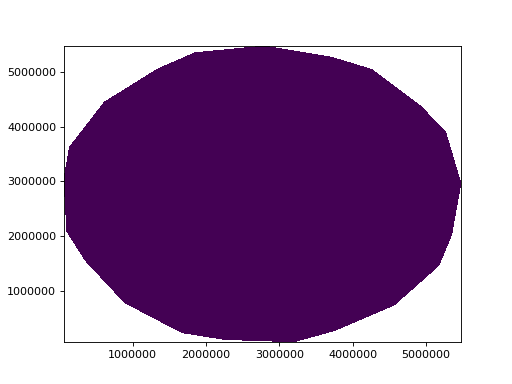

In [37]:
fig, ax = pyplot.subplots()
scha.polar_tricontour(a[0][1], thetav, phiv, theta_0, ax, cmap='viridis', scale="minmax")

In [11]:
import importlib
importlib.reload(mehler)

<module 'mehler' from '/home/josecper/Programs/python/mehler.py'>

In [12]:
import rscha
importlib.reload(rscha)

<module 'rscha' from '/home/josecper/Programs/python/rscha.py'>

In [13]:
Axyz_mehler=rscha.mehler_condition_matrix_xyz(thetav, phiv, m_mehler, theta_0)

In [14]:
Axyz_legendre=numpy.concatenate(scha.condition_matrix_xyz(thetav, phiv, (k_even, m_even, n_even)), axis=0)

In [135]:
Axyz=numpy.concatenate((Axyz_legendre, Axyz_mehler), axis=1)

In [136]:
Axyz.shape

(1104, 9)

<IPython.core.display.Javascript object>


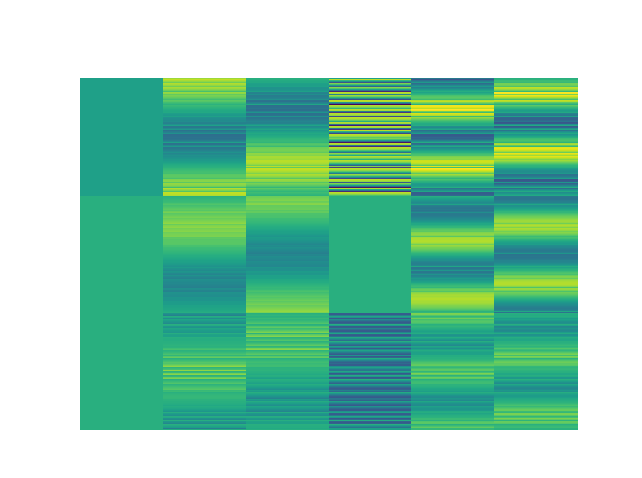

(0.0, 6.0, 0.0, 1200.0)

In [137]:
fig, ax = pyplot.subplots()
ax.pcolormesh(Axyz_legendre, cmap="viridis")
ax.axis('off')

In [47]:
numpy.max(Axyz_legendre)

NameError: name 'Axyz_legendre' is not defined

In [46]:
numpy.max(Axyz)

5.3605311970590295

In [2]:
import scha

In [55]:
Axyz = scha.condition_matrix_xyz(thetav, phiv, (k, m, n))

<IPython.core.display.Javascript object>


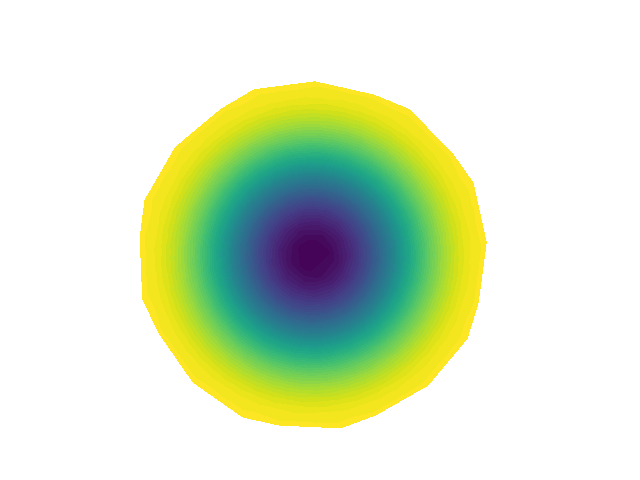

2 2 6.68756770123


(0.0, 6000000.0, 0.0, 6000000.0)

In [56]:
fig, ax = pyplot.subplots(subplot_kw={'aspect':'equal'})
scha.polar_tricontour(Axyz[2][:, 4], thetav, phiv, theta_0, ax, cmap='viridis', scale="minmax")
print(k_even[4], m_even[4], n_even[4])
ax.axis('off')